In [356]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import math

In [357]:
SEQUENCE_LENGTH = 63
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 1e-4
D_MODEL = 128
NHEAD = 8
OUTPUT_SIZE = 14
NUM_LAYERS = 3
TARGET_COLS = ['open', 'close','high','low']
OUTPUT_DIM = len(TARGET_COLS)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [358]:
import torch
import torch.nn as nn

class OHLCConvNet(nn.Module):
    def __init__(self, input_dim, output_steps=OUTPUT_SIZE, output_dim=OUTPUT_DIM):
        super().__init__()
        self.output_steps = output_steps
        self.output_dim = output_dim
        
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()

        self.global_pool = nn.AdaptiveAvgPool1d(1)  # shape -> (batch, channels, 1)

        self.fc = nn.Linear(256, output_steps * output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x = x.permute(0, 2, 1)  # to (batch_size, input_dim, seq_len)

        x = self.relu1(self.conv1(x))  # (batch_size, 64, seq_len)
        x = self.relu2(self.conv2(x))  # (batch_size, 128, seq_len)
        x = self.relu3(self.conv3(x))  # (batch_size, 256, seq_len)

        x = self.global_pool(x)        # (batch_size, 256, 1)
        x = x.squeeze(-1)              # (batch_size, 256)

        x = self.fc(x)                 # (batch_size, output_steps * output_dim)
        x = x.view(-1, self.output_steps, self.output_dim)

        return x


In [359]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class OHLCTransformer(nn.Module):
    def __init__(self, input_dim, d_model=D_MODEL, nhead=NHEAD, 
                 num_layers=NUM_LAYERS, output_steps=OUTPUT_SIZE, output_dim=OUTPUT_DIM):
        super().__init__()
        self.input_linear = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dropout=0.2)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_linear = nn.Linear(d_model, output_steps * output_dim)
        
    def forward(self, x):
        x = self.input_linear(x)  # (batch_size, seq_len, d_model)
        x = x.permute(1, 0, 2)   # (seq_len, batch_size, d_model)
        x = self.pos_encoder(x)
        x = self.transformer(x)  # (seq_len, batch_size, d_model)
        x = x[-1]                # (batch_size, d_model)
        x = self.output_linear(x).view(-1, OUTPUT_SIZE, OUTPUT_DIM)
        return x


In [365]:
class OHLCDataset(Dataset):
    def __init__(self, csv_path, sequence_length=63, output_size=14, target_cols=None):
        self.sequence_length = sequence_length
        self.output_size = output_size
        self.target_cols = target_cols or ['high', 'open', 'close', 'low']
        
        # Load and preprocess
        df = pd.read_csv(csv_path)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.sort_values('timestamp', inplace=True)
        
        # Handle booleans/NaNs
        for col in df.columns:
            if df[col].dtype == object and set(df[col].dropna().unique()) <= {'TRUE', 'FALSE'}:
                df[col] = df[col].map({'FALSE': 0, 'TRUE': 1})
        df = df.fillna(method='ffill').fillna(0)
        
        # Split features & targets
        self.feature_cols = df.columns.drop(['id', 'timestamp', 'cross_prev_hl', 'ema_trend_st', 'ema_trend_lt'] + self.target_cols)
        self.features = df[self.feature_cols]
        self.targets = df[self.target_cols]
        
        # Normalize (fit on features only)
        self.feature_scaler = StandardScaler()
        self.scaled_features = self.feature_scaler.fit_transform(self.features)
        
        # Normalize targets separately
        self.target_scaler = StandardScaler()
        self.scaled_targets = self.target_scaler.fit_transform(self.targets)
        
        # Create sequences
        self.X, self.y = self.create_sequences()
    
    def create_sequences(self):
        X, y = [], []
        for i in range(len(self.scaled_features) - self.sequence_length - self.output_size + 1):
            X.append(self.scaled_features[i:i+self.sequence_length])
            y.append(self.scaled_targets[i+self.sequence_length:i+self.sequence_length+self.output_size].flatten())
        return np.array(X), np.array(y)
    
    def inverse_transform_target(self, y):
        y = y.reshape(-1, self.output_size, len(self.target_cols))
        return self.target_scaler.inverse_transform(y.reshape(-1, len(self.target_cols))).reshape(y.shape)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return (torch.FloatTensor(self.X[idx]),
                torch.FloatTensor(self.y[idx]))

In [366]:
dataset = OHLCDataset('data.csv')
# Splitting the dataset into train (80%), validation (10%), and test (10%) sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Create subsets for train, validation, and test sets using proper indices
train_dataset = torch.utils.data.Subset(dataset, list(range(train_size)))
val_dataset = torch.utils.data.Subset(dataset, list(range(train_size, train_size + val_size)))
test_dataset = torch.utils.data.Subset(dataset, list(range(train_size + val_size, len(dataset))))

# DataLoader for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("Input dimension:", len(dataset.feature_cols))
#model = OHLCTransformer(input_dim=len(dataset.feature_cols)).to(DEVICE)
model = OHLCConvNet(input_dim=len(dataset.feature_cols)).to(DEVICE)
print("Num paramse:-", sum(p.numel() for p in model.parameters())/1e6, "M")
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

/var/folders/g6/f8dm2s3j49v8_h2b1tdytvmr0000gn/T/ipykernel_73736/711418149.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(0)


Input dimension: 37
Num paramse:- 0.144824 M


In [367]:
best_val_loss = float('inf')
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output.view(-1, OUTPUT_DIM*OUTPUT_SIZE), y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            output = model(X)
            val_loss += criterion(output.view(-1, OUTPUT_SIZE*OUTPUT_DIM), y).item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    print(f'Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/100 - Train Loss: 0.279015, Val Loss: 0.327681
Epoch 2/100 - Train Loss: 0.077255, Val Loss: 0.014813
Epoch 3/100 - Train Loss: 0.006535, Val Loss: 0.007109
Epoch 4/100 - Train Loss: 0.003687, Val Loss: 0.004805
Epoch 5/100 - Train Loss: 0.003199, Val Loss: 0.003818
Epoch 6/100 - Train Loss: 0.002987, Val Loss: 0.003245
Epoch 7/100 - Train Loss: 0.002712, Val Loss: 0.002970
Epoch 8/100 - Train Loss: 0.002487, Val Loss: 0.002897
Epoch 9/100 - Train Loss: 0.002306, Val Loss: 0.002959
Epoch 10/100 - Train Loss: 0.002163, Val Loss: 0.003099
Epoch 11/100 - Train Loss: 0.002046, Val Loss: 0.003268
Epoch 12/100 - Train Loss: 0.001950, Val Loss: 0.003443
Epoch 13/100 - Train Loss: 0.001868, Val Loss: 0.003595
Epoch 14/100 - Train Loss: 0.001799, Val Loss: 0.003702
Epoch 15/100 - Train Loss: 0.001736, Val Loss: 0.003763
Epoch 16/100 - Train Loss: 0.001682, Val Loss: 0.003756
Epoch 17/100 - Train Loss: 0.001633, Val Loss: 0.003691
Epoch 18/100 - Train Loss: 0.001588, Val Loss: 0.003571
E

In [368]:
import matplotlib.pyplot as plt
import torch

def predict(model, dataset, sample_idx=-1):
    #sample_idx = sample_idx if sample_idx != -1 else len(dataset) - 1
    model.eval()
    
    with torch.no_grad():
        X, y = dataset[sample_idx]
        prediction = model(X.unsqueeze(0).to(DEVICE)).cpu().numpy()
        print(np.shape(prediction))

    # Reshape and inverse transform
    true_values = dataset.y[sample_idx].reshape(OUTPUT_SIZE, OUTPUT_DIM)
    prediction = dataset.inverse_transform_target(prediction)
    true_values = dataset.inverse_transform_target(true_values)[0]

    # Extract timestamps for plotting
    timestamps = [
        dataset.df.iloc[sample_idx + i + dataset.sequence_length]['timestamp']
        for i in range(OUTPUT_SIZE)
    ]

    # Plotting
    fig, axs = plt.subplots(OUTPUT_DIM, 1, figsize=(10, 8), sharex=True)
    labels = TARGET_COLS
    
    for i in range(OUTPUT_DIM):
        axs[i].plot(timestamps, prediction[0, :, i], label='Predicted', marker='o')
        axs[i].plot(timestamps, true_values[:, i], label='Actual', marker='x')
        axs[i].set_ylabel(labels[i])
        axs[i].legend()
        axs[i].grid(True)

    axs[-1].set_xlabel("Timestamp")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Load best model and predict
#model.load_state_dict(torch.load('best_model.pth'))
predict(model, dataset,sample_idx=21151)

(1, 14, 4)


AttributeError: 'OHLCDataset' object has no attribute 'df'

In [369]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, dataset):
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(DEVICE)
            output = model(X).cpu().numpy()
            y = y.numpy()

            # Inverse transform predictions and true values
            output = dataset.inverse_transform_target(output)
            y = dataset.inverse_transform_target(y)

            preds.append(output)
            trues.append(y)

    preds = np.concatenate(preds, axis=0)  # (samples, OUTPUT_SIZE, OUTPUT_DIM)
    trues = np.concatenate(trues, axis=0)

    rmse_list = []
    r2_list = []

    for i in range(OUTPUT_DIM):
        pred_vals = preds[:, :, i].reshape(-1)
        true_vals = trues[:, :, i].reshape(-1)

        rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
        r2 = r2_score(true_vals, pred_vals)

        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f'{TARGET_COLS[i]} - RMSE: {rmse:.4f}, R²: {r2:.4f}')

        # Plotting predicted vs actual
        plt.figure(figsize=(10, 4))
        plt.plot(true_vals, label='Actual', alpha=0.7)
        plt.plot(pred_vals, label='Predicted', alpha=0.7)
        plt.title(f'{TARGET_COLS[i]} - Actual vs Predicted')
        plt.xlabel('Time Steps')
        plt.ylabel(TARGET_COLS[i])
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return rmse_list, r2_list


open - RMSE: 534.8681, R²: 0.7480


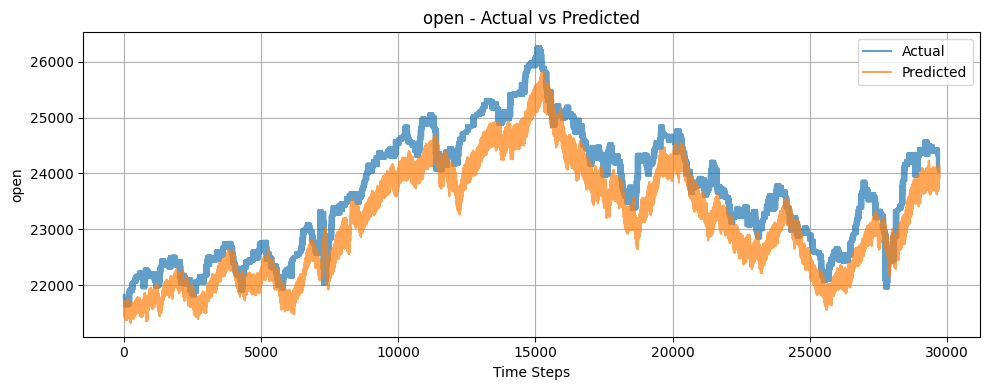

close - RMSE: 525.9344, R²: 0.7574


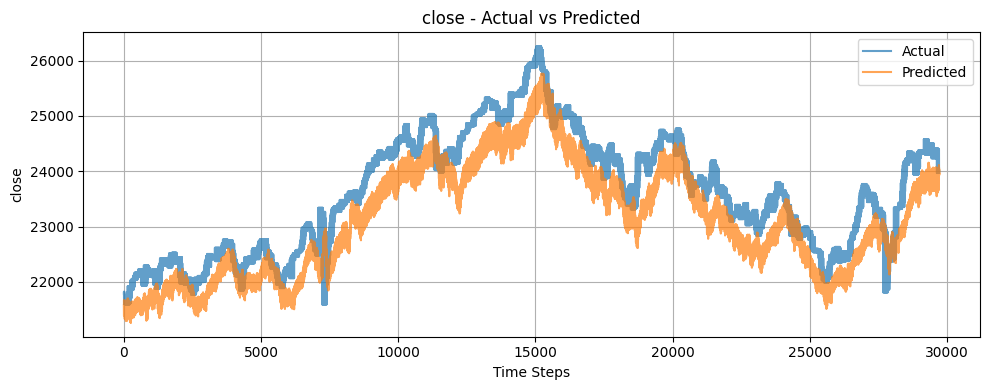

high - RMSE: 545.7514, R²: 0.7383


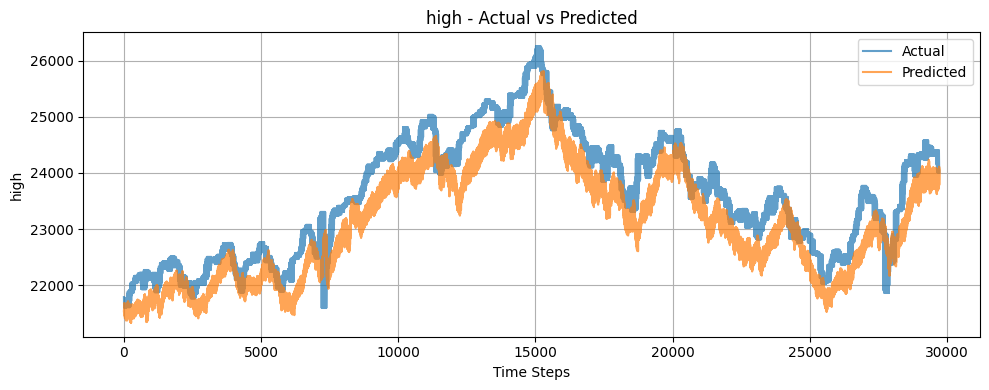

low - RMSE: 509.7789, R²: 0.7728


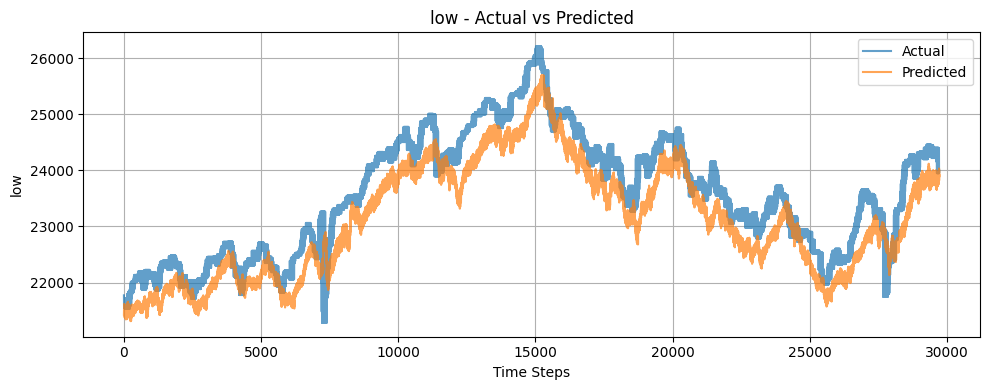

([np.float64(534.8681496406381),
  np.float64(525.9344362655862),
  np.float64(545.7513742538813),
  np.float64(509.77890428106184)],
 [0.7479978799819946,
  0.7574272155761719,
  0.7383103966712952,
  0.7727931141853333])

In [370]:
evaluate_model(model, test_loader, dataset)

In [ ]:
# Get one batch from val_loader
for X_batch, y_batch in test_loader:
    X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
    
    # Forward pass
    model.eval()
    with torch.no_grad():
        output = model(X_batch)

    # Move to CPU and convert to numpy
    preds = output.cpu().numpy()
    trues = y_batch.cpu().numpy()

    # Inverse transform
    preds_inv = dataset.inverse_transform_target(preds)
    trues_inv = dataset.inverse_transform_target(trues)
    # Print first sample
    print("Predicted (inverse transformed):")
    print(preds_inv[0])  # shape: (OUTPUT_SIZE, OUTPUT_DIM)

    print("\nActual (inverse transformed):")
    print(trues_inv[0])  # shape: (OUTPUT_SIZE, OUTPUT_DIM)

    break  # Only one batch


Predicted (inverse transformed):
[[22348.1336856  22363.3892845  22426.97411003 22262.9356195 ]
 [22274.09129892 22392.53564101 22479.37869911 22511.34646675]
 [22469.17445397 22338.93990415 22439.30820281 22331.03644689]
 [22268.58285287 22407.27954154 22480.22341969 22362.72748383]
 [22142.86423069 22504.76358433 22412.76561028 22326.65015543]
 [22566.97880304 22406.18171604 22342.89868643 22382.80442617]
 [22398.76794088 22240.79183302 22522.19828219 22295.79546837]
 [22354.37581061 22526.24337271 22339.88452541 22274.39452184]
 [22373.91196429 22357.14377604 22389.40130335 22374.68962464]
 [22438.20383559 22543.56078953 22493.6718663  22376.74543497]
 [22428.30632426 22377.47501002 22576.44992413 22267.1277583 ]
 [22470.25480925 22480.74995225 22494.14339884 22187.87646505]
 [22515.98421252 22489.37191472 22311.61471701 22411.39876082]
 [22432.60367967 22562.26999935 22408.11867016 22359.30611156]]

Actual (inverse transformed):
[[22671.10007595 22661.00015212 22674.35023882 22657.